### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier


In [17]:
neonatal_df = pd.read_excel(r'D:\Chetan-PC\DataSets\DMML\Data 2021-02-27 15-23.xlsx')

In [18]:
neonatal_df.rename(columns={'WHO Region':'region','World Bank Income Group':'income_group', 'Country ISO Code':'country_code'}, inplace=True)

### EDA

In [19]:
neonatal_df.describe()

,Year,Sex,Global,Value
count,30000.00000,0.0,0.0,30000.000000
mean,2008.49660,NaN,NaN,1327.957963
std,5.18996,NaN,NaN,11348.006928
min,2000.00000,NaN,NaN,0.000000
25%,2004.00000,NaN,NaN,0.000000
50%,2008.00000,NaN,NaN,9.178362
75%,2013.00000,NaN,NaN,192.601105
max,2017.00000,NaN,NaN,403786.875000


<AxesSubplot:>

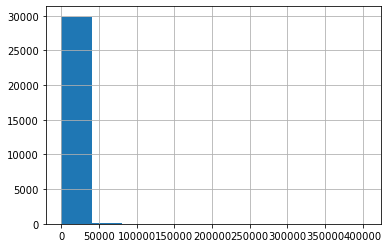

In [20]:
neonatal_df['Value'].hist()

In [21]:
neonatal_df['region'].value_counts()

Africa                   8316
Europe                   8064
Americas                 5796
Western Pacific          3288
Eastern Mediterranean    2772
South-East Asia          1764
Name: region, dtype: int64

In [22]:
neonatal_df['income_group'].value_counts()

Upper middle income    9336
High income            8568
Lower middle income    7056
Low income             5040
Name: income_group, dtype: int64

### Data cleaning

In [23]:
neonatal_df.drop(columns = ['Country', 'Sex', 'Global', 'Age Group'], inplace=True)
neonatal_df = neonatal_df.dropna()

In [24]:
#Label Encoding on country code column
neonatal_df['country_code'] = neonatal_df['country_code'].astype('category')
neonatal_df['country_code_cat'] = neonatal_df['country_code'].cat.codes

There are 120 unique country codes, so i tried three methods for creating dummies for this column:
1. Label Encoding
2. OnehotEncoding
3. MeanEncoding

In [25]:
#Label Encoding for Region, Cause and Income Group
neonatal_df['region'] = neonatal_df['region'].astype('category')
neonatal_df['region_cat'] = neonatal_df['region'].cat.codes
neonatal_df['Cause'] = neonatal_df['Cause'].astype('category')
neonatal_df['cause_cat'] = neonatal_df['Cause'].cat.codes#This is my Target Variable
neonatal_df['income_group'] = neonatal_df['income_group'].astype('category')
neonatal_df['income_group_cat'] = neonatal_df['income_group'].cat.codes

In [26]:
#OneHotEncoding on country_code column
oe_style = OneHotEncoder()
oe_results = oe_style.fit_transform(neonatal_df[["country_code"]])
temp_df = pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_)
for col in temp_df.columns:
    neonatal_df[col]=temp_df[col]

In [27]:
'''Mean Encoding on country_code column, this was implemented 
 to capture information within labels or categories, rendering more predictive features.'''

country_encd_mean = neonatal_df.groupby('country_code')['Value'].mean()
neonatal_df['country_encd_mean'] = neonatal_df['country_code'].map(country_encd_mean)
neonatal_df[['country_code', 'country_encd_mean']].head()

,country_code,country_encd_mean
0,AFG,3961.924645
1,AFG,3961.924645
2,AFG,3961.924645
3,AFG,3961.924645
4,AFG,3961.924645


### Feature Dataframe Creation

In [64]:
feature_cols_label_encdng = ['Value','region_cat', 'income_group_cat', 'country_code_cat']
feature_cols_onehot = [col for col in neonatal_df.columns if col not in ['region', 
                                                                       'income_group',
                                                                       'country_code',
                                                                       'Cause',
                                                                       'cause_cat',
                                                                       'country_code_cat'
                                                                       'country_encd_mean'
                                                                      ]]
feature_cols_mean_encodng = ['Value','region_cat', 'income_group_cat', 'country_encd_mean']



In [72]:
feature_cols_onehot

['Year',
 'Value',
 'region_cat',
 'income_group_cat',
 ('AFG',),
 ('AGO',),
 ('ALB',),
 ('AND',),
 ('ARG',),
 ('ARM',),
 ('ATG',),
 ('AUS',),
 ('AUT',),
 ('AZE',),
 ('BDI',),
 ('BEL',),
 ('BEN',),
 ('BFA',),
 ('BGD',),
 ('BGR',),
 ('BHR',),
 ('BHS',),
 ('BIH',),
 ('BLR',),
 ('BLZ',),
 ('BOL',),
 ('BRA',),
 ('BRB',),
 ('BRN',),
 ('BTN',),
 ('BWA',),
 ('CAF',),
 ('CAN',),
 ('CHL',),
 ('CHN',),
 ('CIV',),
 ('CMR',),
 ('COD',),
 ('COG',),
 ('COK',),
 ('COL',),
 ('COM',),
 ('CPV',),
 ('CRI',),
 ('CUB',),
 ('CYP',),
 ('CZE',),
 ('DEU',),
 ('DJI',),
 ('DMA',),
 ('DNK',),
 ('DOM',),
 ('DZA',),
 ('ECU',),
 ('EGY',),
 ('ERI',),
 ('EST',),
 ('ETH',),
 ('FIN',),
 ('FJI',),
 ('FRA',),
 ('FSM',),
 ('GAB',),
 ('GEO',),
 ('GHA',),
 ('GIN',),
 ('GMB',),
 ('GNB',),
 ('GNQ',),
 ('GRC',),
 ('GRD',),
 ('GTM',),
 ('GUY',),
 ('HND',),
 ('HRV',),
 ('HTI',),
 ('HUN',),
 ('IDN',),
 ('IND',),
 ('IRL',),
 ('IRN',),
 ('IRQ',),
 ('ISL',),
 ('ISR',),
 ('ITA',),
 ('JAM',),
 ('JOR',),
 ('JPN',),
 ('KAZ',),
 ('KEN',),

Feature Dataframe with Label Encoded Columns

In [13]:
feature_df_label = neonatal_df[feature_cols_label_encdng]
feature_df_label

,Value,region_cat,income_group_cat,country_code_cat
0,4356.749023,2,1,0
1,15645.974609,2,1,0
2,2904.053467,2,1,0
3,654.522766,2,1,0
4,0.000000,2,1,0
...,...,...,...,...
29995,0.000000,5,3,115
29996,0.000000,5,3,115
29997,0.240370,5,3,115
29998,0.003885,5,3,115


Fature DataFrame with OnehotEncoded Categroical Column

In [73]:
feature_df_onehot = neonatal_df[feature_cols_onehot]
feature_df_onehot

C:\Users\cheta\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,Year,Value,region_cat,income_group_cat,"(AFG,)","(AGO,)","(ALB,)","(AND,)","(ARG,)","(ARM,)",...,"(MRT,)","(MUS,)","(MWI,)","(MYS,)","(NAM,)","(NRU,)","(PRK,)","(SLV,)","(SWZ,)","(TCD,)"
0,2000.0,4356.749023,2,1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2000.0,15645.974609,2,1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2000.0,2904.053467,2,1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2000.0,654.522766,2,1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2000.0,0.000000,2,1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,2000.0,0.000000,5,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
29996,2000.0,0.000000,5,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
29997,2000.0,0.240370,5,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
29998,2000.0,0.003885,5,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Feature DataFrame with Country encoded via Mean Encoding

In [15]:
feature_df_mean = neonatal_df[feature_cols_mean_encodng]
feature_df_mean

,Value,region_cat,income_group_cat,country_encd_mean
0,4356.749023,2,1,3961.924645
1,15645.974609,2,1,3961.924645
2,2904.053467,2,1,3961.924645
3,654.522766,2,1,3961.924645
4,0.000000,2,1,3961.924645
...,...,...,...,...
29995,0.000000,5,3,0.362967
29996,0.000000,5,3,0.362967
29997,0.240370,5,3,0.362967
29998,0.003885,5,3,0.362967


In [ ]:
X

In [ ]:
# Split dataset into training set and test set
# X_train, X_test, y_train, y_test = train_test_split(feature_df, neonatal_df['cause_cat'], test_size=0.3, random_state=50) # 70% training and 30% test


### KNN Classification

#### Without Scaling

##### On Label Encoded Data

In [29]:
x_train, x_test, y_train, y_test = train_test_split(feature_df_label,
                                                          neonatal_df['cause_cat'],
                                                          test_size=0.3,
                                                          random_state=50)\
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

#Train the model using the training sets
knn.fit(x_train, y_train)
train_pred = knn.predict(x_train)
y_pred = knn.predict(x_test)
print("Train Accuracy", metrics.accuracy_score(y_train, train_pred))
print("Test Accuracy", metrics.accuracy_score(y_test, y_pred))
# pd.DataFrame(confusion_matrix(y_test, y_pred))

Train Accuracy 0.5061428571428571
Test Accuracy 0.38866666666666666


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,271,50,48,22,13,33,4,4,18,65,38,35,29,2
1,56,283,77,5,0,13,1,0,8,57,4,69,50,2
2,70,89,274,6,1,14,0,0,20,34,2,70,39,7
3,48,26,28,201,73,20,69,54,50,17,18,17,7,53
4,25,10,3,76,274,12,71,51,17,2,48,3,4,28
5,75,35,13,39,19,319,12,8,36,29,32,7,9,21
6,28,4,0,91,95,0,173,210,13,0,4,0,0,17
7,31,7,0,90,80,0,203,178,14,0,8,0,0,22
8,47,18,28,65,56,43,51,30,251,14,37,13,12,24
9,81,88,57,9,2,26,0,0,19,257,9,28,64,6


##### On OneHot Encoded Data

In [30]:
x_train, x_test, y_train, y_test = train_test_split(feature_df_onehot,
                                                          neonatal_df['cause_cat'],
                                                          test_size=0.3,
                                                          random_state=50)
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

#Train the model using the training sets
knn.fit(x_train, y_train)
train_pred = knn.predict(x_train)
y_pred = knn.predict(x_test)
print("Train Accuracy", metrics.accuracy_score(y_train, train_pred))
print("Test Accuracy", metrics.accuracy_score(y_test, y_pred))
pd.DataFrame(confusion_matrix(y_test, y_pred))

Train Accuracy 0.5937619047619047
Test Accuracy 0.5133333333333333


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,361,8,32,10,4,33,13,7,11,96,28,1,24,4
1,20,352,63,0,0,4,0,0,0,39,0,105,41,1
2,52,70,385,0,0,1,0,0,0,14,0,66,38,0
3,12,0,0,298,54,43,80,60,42,0,8,0,2,82
4,10,0,0,104,285,9,65,57,18,0,39,0,4,33
5,51,3,0,36,9,398,9,20,39,17,34,0,9,29
6,12,0,0,106,67,4,199,206,8,0,0,0,6,27
7,10,0,0,95,71,3,209,192,18,0,0,0,4,31
8,13,0,0,92,32,64,30,44,321,6,31,0,5,51
9,100,62,38,2,0,16,0,0,3,369,2,3,47,4


##### On MeanEncoded Data

In [31]:
x_train, x_test, y_train, y_test = train_test_split(feature_df_mean,
                                                          neonatal_df['cause_cat'],
                                                          test_size=0.3,
                                                          random_state=50)\
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

#Train the model using the training sets
knn.fit(x_train, y_train)
train_pred = knn.predict(x_train)
y_pred = knn.predict(x_test)
print("Train Accuracy", metrics.accuracy_score(y_train, train_pred))
print("Test Accuracy", metrics.accuracy_score(y_test, y_pred))
pd.DataFrame(confusion_matrix(y_test, y_pred))

Train Accuracy 0.582047619047619
Test Accuracy 0.4988888888888889


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,368,12,31,7,3,31,8,0,14,103,29,1,20,5
1,22,346,66,1,0,3,0,0,0,36,0,100,51,0
2,64,100,316,0,0,1,0,0,0,23,0,79,43,0
3,28,0,0,300,63,45,60,48,58,0,14,0,0,65
4,17,0,0,86,311,14,56,54,11,0,45,0,0,30
5,63,1,0,33,15,399,8,7,48,16,35,0,5,24
6,28,0,0,96,104,3,180,182,11,0,4,0,0,27
7,23,0,0,108,97,5,177,166,9,0,8,0,0,40
8,34,0,0,81,45,67,33,26,321,7,35,0,1,39
9,101,71,38,0,1,15,2,0,4,354,5,4,50,1


#### With Scaled Data

In [41]:
scaler = StandardScaler()
scaler.fit(neonatal_df['Value'].values.reshape(-1,1))
X = scaler.transform(neonatal_df['Value'].values.reshape(-1,1))


##### On Label Encoded Data

In [49]:
feature_df_label['values_scaled'] = X
feature_df_label_new = feature_df_label[feature_df_label.columns[1:]]
x_train, x_test, y_train, y_test = train_test_split(feature_df_label_new,
                                                          neonatal_df['cause_cat'],
                                                          test_size=0.3,
                                                          random_state=50)\
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

#Train the model using the training sets
knn.fit(x_train, y_train)
train_pred = knn.predict(x_train)
y_pred = knn.predict(x_test)
print("Train Accuracy", metrics.accuracy_score(y_train, train_pred))
print("Test Accuracy", metrics.accuracy_score(y_test, y_pred))
pd.DataFrame(confusion_matrix(y_test, y_pred))

<ipython-input-49-9737a915dde5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df_label['values_scaled'] = X


Train Accuracy 0.6048571428571429
Test Accuracy 0.5197777777777778


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,374,9,39,10,20,26,9,2,6,86,28,1,21,1
1,12,384,64,0,0,3,0,0,0,40,0,89,33,0
2,51,65,416,0,0,1,0,0,0,13,0,54,26,0
3,14,0,7,283,139,42,53,40,33,0,8,0,0,62
4,22,0,6,72,326,17,69,37,4,0,39,0,0,32
5,53,2,5,37,29,399,5,5,36,17,35,0,4,27
6,30,0,4,95,128,7,177,179,0,0,0,0,0,15
7,20,0,7,102,133,6,184,159,0,0,0,0,0,22
8,32,0,1,64,100,60,20,27,313,6,31,0,1,34
9,89,59,42,0,4,16,0,0,5,371,2,3,50,5


##### On OneHot Encoded Data

In [56]:
feature_df_onehot['values_scaled'] = X
feature_df_onehot_new = feature_df_onehot[feature_df_onehot.columns[1:]]
x_train, x_test, y_train, y_test = train_test_split(feature_df_onehot_new,
                                                          neonatal_df['cause_cat'],
                                                          test_size=0.3,
                                                          random_state=50)\
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

#Train the model using the training sets
knn.fit(x_train, y_train)
train_pred = knn.predict(x_train)
y_pred = knn.predict(x_test)
print("Train Accuracy", metrics.accuracy_score(y_train, train_pred))
print("Test Accuracy", metrics.accuracy_score(y_test, y_pred))
pd.DataFrame(confusion_matrix(y_test, y_pred))

<ipython-input-56-fea4e24a8d15>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df_onehot['values_scaled'] = X


Train Accuracy 0.6045238095238096
Test Accuracy 0.5211111111111111


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,374,9,34,8,13,32,4,6,8,86,28,1,19,10
1,18,384,57,0,1,3,0,0,0,40,0,89,33,0
2,56,65,411,0,0,1,0,0,0,13,0,54,26,0
3,19,0,0,278,65,60,33,61,59,0,11,0,0,95
4,15,0,0,63,300,21,50,48,20,0,48,0,0,59
5,49,2,0,26,23,402,6,16,45,17,37,0,4,27
6,19,0,0,98,80,21,162,196,12,0,4,0,0,43
7,14,0,0,93,73,14,179,179,16,0,10,0,0,55
8,22,0,0,62,39,69,28,35,326,6,37,0,1,64
9,92,58,38,2,1,15,0,0,5,371,2,3,51,8


##### On MeanEncoded Data

In [57]:
feature_df_mean['values_scaled'] = X
feature_df_mean_new = feature_df_mean[feature_df_mean.columns[1:]]
x_train, x_test, y_train, y_test = train_test_split(feature_df_mean_new,
                                                          neonatal_df['cause_cat'],
                                                          test_size=0.3,
                                                          random_state=50)\
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

#Train the model using the training sets
knn.fit(x_train, y_train)
train_pred = knn.predict(x_train)
y_pred = knn.predict(x_test)
print("Train Accuracy", metrics.accuracy_score(y_train, train_pred))
print("Test Accuracy", metrics.accuracy_score(y_test, y_pred))
pd.DataFrame(confusion_matrix(y_test, y_pred))

<ipython-input-57-c0d6f03c2ae6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df_mean['values_scaled'] = X


Train Accuracy 0.6044761904761905
Test Accuracy 0.5208888888888888


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,373,8,39,20,4,30,1,7,8,87,28,1,21,5
1,11,384,64,0,0,3,0,1,0,40,0,89,33,0
2,51,65,416,0,0,1,0,0,0,13,0,54,26,0
3,21,0,7,313,63,52,73,37,40,0,8,0,0,67
4,15,0,6,96,305,20,69,34,15,0,39,0,0,25
5,49,2,5,47,21,399,13,3,37,17,35,0,4,22
6,22,0,4,121,80,16,186,169,13,0,0,0,0,24
7,12,0,7,119,86,8,217,146,9,0,0,0,0,29
8,28,0,1,96,47,64,24,27,321,6,31,0,1,43
9,87,58,42,3,2,16,0,1,5,371,2,3,51,5


### KFold Implementation

In [ ]:

accuracy_list1=[]
cv = KFold(n_splits=10, random_state=42, shuffle=False)
for train_index, test_index in cv.split(X):
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], neonatal_df['cause_cat'].iloc[train_index], neonatal_df['cause_cat'].iloc[test_index]
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy_list1.append(metrics.accuracy_score(y_test, y_pred))
    print(pd.DataFrame(confusion_matrix(y_test,y_pred)))

In [ ]:
accuracy_list1

### Random Forest 

#### OneHot Encoded Data

In [78]:
feature_df_onehot['values_scaled'] = X
feature_df_onehot_new = feature_df_onehot[feature_df_onehot.columns[2:]]

<ipython-input-78-7867685ac97d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df_onehot['values_scaled'] = X


In [82]:
feature_df_mean['values_scaled'] = X
feature_df_mean_new = feature_df_mean[feature_df_mean.columns[1:]]

In [83]:
feature_df_mean_new

,region_cat,income_group_cat,country_encd_mean,values_scaled
0,2,1,3961.924645,0.266905
1,2,1,3961.924645,1.261742
2,2,1,3961.924645,0.138890
3,2,1,3961.924645,-0.059345
4,2,1,3961.924645,-0.117023
...,...,...,...,...
29995,5,3,0.362967,-0.117023
29996,5,3,0.362967,-0.117023
29997,5,3,0.362967,-0.117002
29998,5,3,0.362967,-0.117023


In [84]:

x_train, x_test, y_train, y_test = train_test_split(feature_df_mean_new,
                                                          neonatal_df['cause_cat'],
                                                          test_size=0.3,
                                                          random_state=50)
model = RandomForestClassifier(n_estimators=1000, 
                               random_state=50)

# Fit on training data
model.fit(x_train, y_train)


n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

# Training predictions (to demonstrate overfitting)
train_rf_predictions = model.predict(x_train)
print("Training Accuracy",metrics.accuracy_score(y_train, train_rf_predictions))
#
y_pred_rf = model.predict(x_test)
# rf_probs = model.predict_proba(test)[:, 1]
print("Test Accuracy",metrics.accuracy_score(y_test, y_pred_rf))

Average number of nodes 8586
Average maximum depth 27
Training Accuracy 0.77
Test Accuracy 0.46444444444444444


In [89]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
precision_score(y_test, y_pred_rf, average='weighted')

0.4715613251481802

### CatBoost

#### Data Preparation

In [97]:
# neonatal_df['values_scaled'] = X/
neonatal_df

,Year,region,income_group,country_code,Cause,Value,country_code_cat,region_cat,cause_cat,income_group_cat,...,"(MWI,)","(MYS,)","(NAM,)","(NRU,)","(PRK,)","(SLV,)","(SWZ,)","(TCD,)",country_encd_mean,values_scaled
0,2000.0,Eastern Mediterranean,Low income,AFG,Acute lower respiratory infections,4356.749023,0,2,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3961.924645,0.266905
1,2000.0,Eastern Mediterranean,Low income,AFG,Birth asphyxia and birth trauma,15645.974609,0,2,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3961.924645,1.261742
2,2000.0,Eastern Mediterranean,Low income,AFG,Congenital anomalies,2904.053467,0,2,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3961.924645,0.138890
3,2000.0,Eastern Mediterranean,Low income,AFG,Diarrhoeal diseases,654.522766,0,2,3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3961.924645,-0.059345
4,2000.0,Eastern Mediterranean,Low income,AFG,HIV/AIDS,0.000000,0,2,4,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3961.924645,-0.117023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,2000.0,Western Pacific,Upper middle income,NRU,Measles,0.000000,115,5,7,3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.362967,-0.117023
29996,2000.0,Western Pacific,Upper middle income,NRU,Meningitis/encephalitis,0.000000,115,5,8,3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.362967,-0.117023
29997,2000.0,Western Pacific,Upper middle income,NRU,"Other communicable, perinatal and nutritional ...",0.240370,115,5,9,3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.362967,-0.117002
29998,2000.0,Western Pacific,Upper middle income,NRU,Other noncommunicable diseases,0.003885,115,5,10,3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.362967,-0.117023


In [99]:
cat_boost_df =  neonatal_df[['Year','region', 'income_group',
            'country_code','values_scaled']]

#### Trial

In [111]:
for columns in 
cat_boost_df['Year'] = cat_boost_df['Year'].astype('int') 
cat_boost_df['values_scaled'] = cat_boost_df['values_scaled'].astype('str') 

<ipython-input-111-9c738b989dd6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_boost_df['Year'] = cat_boost_df['Year'].astype('int')
<ipython-input-111-9c738b989dd6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_boost_df['values_scaled'] = cat_boost_df['values_scaled'].astype('str')


In [112]:
cat_boost_df
X_train, X_test, y_train, y_test = train_test_split(cat_boost_df,
                                                          neonatal_df['cause_cat'],
                                                          test_size=0.3,
                                                          random_state=50)

In [109]:
cat_features = list(range(0, cat_boost_df.shape[1]))
print(cat_features)



[0, 1, 2, 3, 4]


In [104]:
!pip install catboost

In [113]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(
    iterations=5, 
    learning_rate=0.1, 
    #loss_function='CrossEntropy'
)


clf.fit(X_train, y_train, 
        cat_features=cat_features, 
        eval_set=(X_test, y_test), 
        verbose=False
)

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 5, 'learning_rate': 0.1}


In [119]:
X_test

,Year,region,income_group,country_code,values_scaled
16609,2016,Europe,Lower middle income,GEO,-0.11662838379107704
5489,2014,Europe,Upper middle income,BIH,-0.11552353238082162
5662,2008,Africa,Upper middle income,BWA,-0.11702320108667498
8055,2017,Americas,High income,CAN,-0.11665869419562105
29047,2004,Eastern Mediterranean,Lower middle income,MAR,0.35446621424639724
...,...,...,...,...,...
564,2004,Africa,Upper middle income,DZA,-0.11701438882084347
29323,2006,Africa,Low income,MOZ,-0.11702320108667498
17766,2009,Americas,Upper middle income,GTM,-0.07808074502946809
17514,2009,Americas,Upper middle income,GRD,-0.11702320108667498


In [117]:
y_pred = clf.predict(data = X_test)

In [118]:
y_pred = clf.predict(data = X_test)
metrics.accuracy_score(y_test,y_pred)

0.13233333333333333

In [ ]:


import matplotlib.pyplot as plt

# # Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, 
                                     [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, 
                                      [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

# evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)
# plt.savefig('roc_auc_curve.png')

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Confusion matrix
pd.DataFrame(confusion_matrix(train_labels, rf_predictions))
# plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
#                       title = 'Health Confusion Matrix')

# plt.savefig('cm.png')

In [ ]:
feature_df

In [ ]:
pd.DataFrame(confusion_matrix(test_labels, rf_predictions))

### PCA implementation

In [ ]:

pca = PCA(n_components= 2, random_state=42)
pca.fit(feature_df)
comp_check = pca.explained_variance_ratio_
# final_comp = comp
print(comp_check)
        
# Final_PCA = PCA(n_components= final_comp,random_state=42)
# Final_PCA.fit(feature_df)
# cluster_df=Final_PCA.transform(feature_df)
# num_comps = comp_check.shape[0]
# print("Using {} components, we can explain {}% of the variability in the original data.".format(final_comp,comp_check.sum()))

In [ ]:
comp_check.sum()

In [120]:
birth_data = pd.read_spss(r'D:\Chetan-PC\DataSets\DMML\Ghana MICS6 SPSS Datasets\bh.sav')
# dict1= scipy.readsav(file_name, idict=None, python_dict=False,uncompressed_file_name=None, verbose=False)

In [122]:
dict(birth_data.isnull().sum())

{'HH1': 0,
 'HH2': 0,
 'LN': 0,
 'WM1': 0,
 'WM2': 0,
 'WM3': 0,
 'WMINT': 0,
 'BH0': 0,
 'BH2': 0,
 'BH3': 0,
 'BH4D': 0,
 'BH4M': 0,
 'BH4Y': 0,
 'BH5': 0,
 'BH6': 2903,
 'BH7': 2903,
 'BH8': 2903,
 'BH9U': 31692,
 'BH9N': 31692,
 'BH10': 0,
 'BH4C': 0,
 'BH4F': 0,
 'BH9C': 31692,
 'BH9F': 31692,
 'BH4E': 34595,
 'BH4G': 34595,
 'BH9D': 34595,
 'BH9G': 34595,
 'HH4': 0,
 'HH6': 0,
 'HH7': 0,
 'WDOI': 0,
 'WDOB': 0,
 'stratum': 0,
 'BHLN': 0,
 'brthord': 0,
 'magebrt': 0,
 'birthint': 0,
 'ethnicity': 0,
 'welevel': 0,
 'disability': 104,
 'insurance': 0,
 'BH4D_first': 0,
 'BH4M_first': 0,
 'BH4Y_first': 0,
 'BH6_first': 103,
 'BH3_last': 0,
 'BH4D_last': 0,
 'BH4M_last': 0,
 'BH4Y_last': 0,
 'BH6_last': 103,
 'OVERSAMPLED': 0,
 'LIST_CAT': 0,
 'wmweight': 0,
 'wscore': 0,
 'windex5': 0,
 'windex10': 0,
 'wscoreu': 20877,
 'windex5u': 20877,
 'windex10u': 20877,
 'wscorer': 13718,
 'windex5r': 13718,
 'windex10r': 13718,
 'PSU': 0}

In [127]:
household_data = pd.read_spss(r'D:\Chetan-PC\DataSets\DMML\Ghana MICS6 SPSS Datasets\hh.sav')

In [128]:
household_data.to_excel('household_full.xlsx', index=False)